<a href="https://colab.research.google.com/github/Btere/CV_related_project/blob/main/fashion_mnist_project1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.utils import make_grid
from torch.optim import SGD, Adam

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



About Dataset:

Fashion-MNIST is a dataset of Zalando's article images, consisting of a training set of 60,000 examples and a test set of 10,000 examples. The image pixel values are 28x28 grayscale image(1, 28,28), associated with a label from 10 classes.
For emphasis, the dataset is an image, that implies we have images and lable(text for the true class- target variable).

The dataset can be used to solve supervised learning task: Precisely binary and multiclass problem.

We can classify outfit based on the class label we have.

When we load an image dataset, there are several preprocessing we can do to the image, before training and evaluting the performance of the model.

1. Resizing:

Adjust the size of the images to a standard size that the model can process. This is especially important for convolutional neural networks (CNNs) which often require inputs of fixed size.

2. Center Crop / Random Crop:

Crop the images either centrally or randomly. Central cropping is often used for evaluation, while random cropping can be used for data augmentation during training.

3. Normalization(batchNormalization):

Normalize the pixel values to have a mean of 0 and a standard deviation of 1. This often helps the model converge faster during training. The mean and standard deviation values are typically computed on the training dataset.

4. Conversion to Tensor:

Convert the image from a PIL Image or numpy array to a PyTorch tensor.

5. Data Augmentation:

Apply random transformations to the images to artificially increase the size of the training dataset. Common augmentations include random horizontal flips, rotations, color jitter, etc.

In [ ]:
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = torchvision.datasets.FashionMNIST(root='./Data_dir', train=True, download=True, transform=transform)
train_images = train_dataset.data
target_class = train_dataset.targets


test_data = torchvision.datasets.FashionMNIST(root='./Data_dir', train=True, download=True, transform=transform)
val_images = test_data.data
val_targets = test_data.targets

#Data Visualization

We randomly visualize some of the dataset we have

In [ ]:
import matplotlib.pyplot as plt

def show_image():
  """We want to visualize the dataset downloaded"""
  col, row = 5, 5
  for i in range(1, col * row + 1):
    sample_idx = torch.randint(len(train_images), size=(1,)).item()
    img = train_images[sample_idx]
    figure = plt.figure(figsize=(9, 9))
    figure.add_subplot(row, col, i)
    plt.axis("off")
    # Squeeze is used to remove the single-dimensional entries from the shape of an array.
    plt.imshow(img.squeeze(), cmap='gray')
  plt.show()

<ipython-input-10-f13198d98e04>:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  figure = plt.figure(figsize=(9, 9))


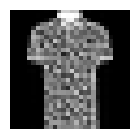

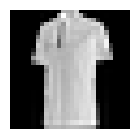

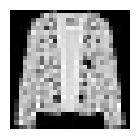

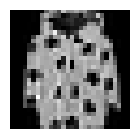

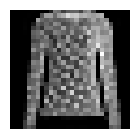

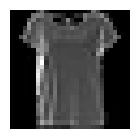

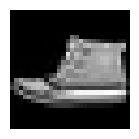

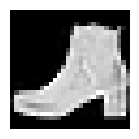

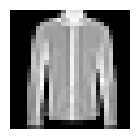

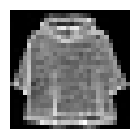

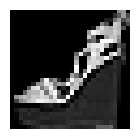

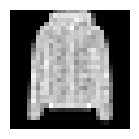

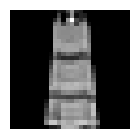

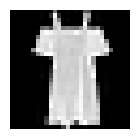

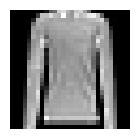

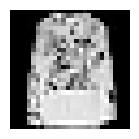

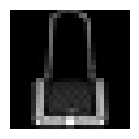

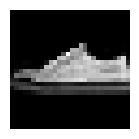

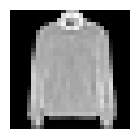

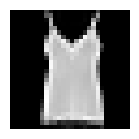

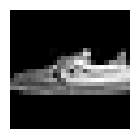

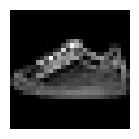

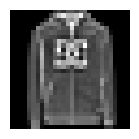

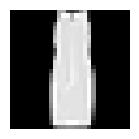

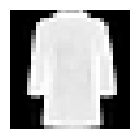

In [ ]:
show_image()

In [ ]:
train_dataset

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: ./Data_dir
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )

In [ ]:
test_data

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: ./Data_dir
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )

In [ ]:
target = test_data.classes
target

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

Further preprocessing anf model training processes

1. visualized transformed data
2. create data loader
3. Build model architecture
4. Training and evaluate model
5. Apply hyperameter tuning after validation set result

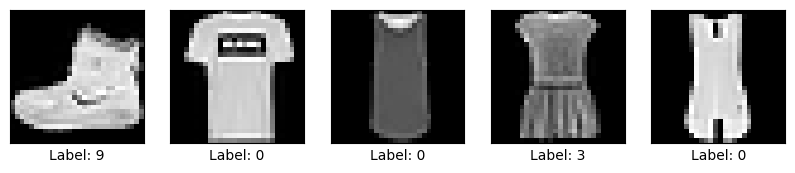

In [ ]:
def show_transformed_images(dataset, num_images=5):
    plt.figure(figsize=(10, 10))
    for i in range(num_images):
        image, label = dataset[i]
        image = image.numpy().squeeze()  # Remove batch and channel dimensions
        mean = 0.5
        std = 0.5
        image = image * std + mean  # Denormalize
        plt.subplot(1, num_images, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(image, cmap='gray')
        plt.xlabel(f'Label: {label}')
    plt.show()

# Display transformed images
show_transformed_images(train_dataset)

We are creating a dataloader, that will load the dataset in batches into the model for training.

Why using TensorDataset?

TensorDataset is a dataset wrapper in PyTorch that allows you to wrap multiple tensors together and treat them as a single dataset. It is particularly useful when you have your data and labels stored as tensors and want to create a dataset that can be used with PyTorch's DataLoader for batching and shuffling.

Assume you have a dataset stored in a single variable and you need to split it into images (features) and labels.

Convert your images and labels into PyTorch tensors. Create TensorDataset:
Use TensorDataset to combine the image tensors and label tensors.
Use DataLoader:

Create a DataLoader to handle batching, shuffling, and loading the data efficiently.

In [ ]:
from typing import Tuple
from torch.utils.data import TensorDataset, DataLoader

def prepare_dataloaders(train_images: torch.tensor, train_targets: torch.tensor, test_images: torch.tensor, test_targets:torch.tensor, batch_size: int = 64, shuffle: bool = True, num_workers=2) -> Tuple[DataLoader, DataLoader]:
  """Prepare dataset for training in batches
  Args:
    train_images: Data used as train input.
    train_targets: Data used as target label.
    test_images: Data used as test input.
    test_targets: Data used as test target.
    batch_size: Number of samples that will be propagated through the network
    shuffle: If true- randomly shuffles data
  """
  train_data = TensorDataset(train_images, train_targets)
  train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)

  test_data = TensorDataset(test_images, test_targets)
  test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)

  return train_dataloader, test_dataloader

In [1]:
train_dataloader, test_dataloader = prepare_dataloaders(train_images, target_class, val_images, val_targets)
#print(train_dataloader, test_dataloader)
#Without the dunder method or dataclass, it is the memory address you get, when you want to print out!

NameError: name 'prepare_dataloaders' is not defined

For the model, we shall be using CNN, Resnet50 and Mobilenet.
FOr CNN, we first create the architecture for the model, before forward feed and backward feed.

Padding: It control the spatial dimensions of the output feature maps and to prevent loss of information at the borders of the input image.

1. Padding of size 1:
When you apply padding of size 1, you add 1 row/column of zeros (assuming zero-padding) to the top, bottom, left, and right of the input image.
If the original image is  5 X 5 after padding it becomes 7 x 7.

2. padding Size 1:

When you apply a padding of size 2, you add 2 rows/columns of zeros to the top, bottom, left, and right of the input image.
If the original image is 5×5, after padding it becomes  9×9 matrix(tensor).


Stride: The stride affect the resolution of the feature map. A stride of 1 preserves the resolution, while a stride of 2 reduces it, making the feature maps smaller and reducing the computational load. it is an hyperparameter

Kernel_size: This is the size of the filter applied to the input image to extract features. 2 x 2, 3 X 3 are mostly used, more filter equal lot of data. It is an hyparameter.

Pooling layer: It reduces  the spatial dimension of the feature map, they help in making the feature map robust to variation of the input image. We have average and maxpooling to use, this enable us to pick the max pixel value or average pixel value durng convolution.

Out_channel: It defines how many different features can be detected. it is an hyperparameter.

Stride

Strides can be used to control the amount of downsampling at each layer of the network. This helps in reducing the computational load while still capturing important features. Pooling Layers: Strides are often used in pooling layers (e.g., max pooling) to downsample the spatial dimensions, making the representations more abstract and focused on the most salient features.

Stride = 1: Minimal reduction in dimensions, essentially moving the filter one pixel at a time.
Stride > 1: Greater reduction in dimensions, as the filter skips pixels, covering a larger area with fewer steps.


Stride, out_channel, padding are applied, the more the size reduces(height &width), then we get relevant info from the image.

Conv2d: This layer applies a 2D convolution operation on the input. The shape of the output feature map depends on the kernel size, stride, and padding.
BatchNorm2d: This layer normalizes the feature maps. It doesn’t change the shape of the feature map.
MaxPool2d: This layer performs max pooling operation which reduces the spatial dimensions of the feature map depending on the kernel size, stride, and padding.


Flattening is the process of converting a multi-dimensional tensor into a 1D tensor. This is typically required before passing the output of convolutional layers to fully connected layers.
Why Flatten? Convolutional layers output multi-dimensional tensors (feature maps) while fully connected layers expect 1D tensors. Flattening bridges this gap.

Different method to flatten:
1. torch.flatten function to flatten the tensor-->x = torch.flatten(x, 1)  # Flatten all dimensions except the batch dimension
2. The view method can be used to reshape the tensor. This method is flexible and allows you to reshape the tensor as needed--> x = x.view(x.size(0), -1)  # Flatten all dimensions except the batch dimension.

3. You can use the nn.Flatten layer as part of the model definition. This layer can be inserted directly into the nn.Sequential container or used in the forward method --> x = self.flatten(x)  # Using nn.Flatten layer.


The fully connected layers in a neural network are designed to combine features learned by the convolutional layers and make predictions. The number of units in these layers can affect:

Capacity and Complexity: More units allow the network to learn more complex relationships but may lead to overfitting if not managed properly.
Computational Load: More units mean more computations and memory usage, impacting training time and resource requirements.

Regularization:

Dropout: Apply dropout regularization to prevent overfitting if you use a large number of units.
L2 Regularization: Add weight regularization to the dense layers to constrain the model’s capacity and help generalize better.
Model Size and Training Resources:

Hardware Constraints: Ensure the number of units doesn’t exceed your computational resources or memory limits.
Training Time: More units mean longer training times, so balance the number of units with available time and resources.


In [ ]:
from pathlib import Path
import torch
import torch.nn as nn
#import torch.nn.functional as F
#from torch import Tensor
#from torch.utils.data import DataLoader
#from torch.utils.data import DataLoader

class FashionMnistModel(nn.Module):
  def __init__(self, device: torch.Tensor) -> None:
    super().__init__()
    self.device = device
    self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 32, kernel_size = 3, padding = 2) #
    self.bn1 = nn.BatchNorm2d(num_features=32)         #we apply batchnorm, which must be same as the out_channel(extract the feature map)
    self.pool1 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
    self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding = 2)
    self.bn2 = nn.BatchNorm2d(num_features=64)
    self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=1)
    self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=2)
    self.bn3 = nn.BatchNorm2d(num_features=128)
    self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2, padding=2)

    self.flatten = nn.Flatten()
    self.fc1 = nn.Linear(in_features=128 * 8 * 8, out_features=512)
    self.fc2 = nn.Linear(in_features=512, out_features=256)
    self.fc3 = nn.Linear(in_features=256, out_features=10) #number of output class:out_feature

    self.softmax = nn.Softmax(dim=1)

    def forward(self, x: Tensor) -> Tensor:
        """Defines the pipeline of the model.

        Args:
            x: Model input data.

        Returns:
            Output generated by the model.
        """
        x = self.conv1(x)
        print(f'After conv1: {x.shape}')
        x = self.bn1(x)
        x = nn.functional.relu(x)
        x = self.pool1(x)
        print(f'After pool1: {x.shape}')

        x = self.conv2(x)
        print(f'After conv1: {x.shape}')
        x = self.bn2(x)
        x = nn.functional.relu(x)
        x = self.pool2(x)
        print(f'After pool2: {x.shape}')

        x = self.conv3(x)
        print(f'After conv3: {x.shape}')
        x = self.bn3(x)
        x = nn.functional.relu(x)
        x = self.pool3(x)
        print(f'After pool3: {x.shape}')

        x = self.flatten(x)
        print(f'After flatten: {x.shape}')
        x = self.fc1(x)
        x = nn.functional.relu(x)
        x = self.fc2(x)
        x = nn.functional.relu(x)
        x = self.fc3(x)
        x = self.softmax(x)

        return x

    def train_model(self, model: FashionMnistModel, dataloader: DataLoader, epoch: int = 5) -> Tuple[float, float]:
     model.train()
    #define loss function
     loss_fn = nn.CrossEntropyLoss()
     # 4. Optimizer
     optimizer = Adam(model.parameters(), lr=0.001)
     for epoch in range(epoch):
      running_loss: float = 0.0
      correct: int = 0
      total: int = 0
      for images, labels in dataloader:
        images, labels = images.to(self.device), labels.to(self.device)
        # Zero the parameter gradients
        optimizer.zero_grad()
        #forward pass
        prediction = model(images)
        #calculate loss
        loss = loss_fn(prediction, labels)
        #backward pass

        loss.backward()
        #update weights
        optimizer.step()

        # Print statistics
        running_loss += loss.item()
        predicted = prediction.argmax(axis=1)
        labels = torch.argmax(labels, dim=1)
        correct += (predicted == labels).sum().item() ## Count correct predictions
        total += labels.size(0) # # Update the total number of samples
      average_loss = running_loss / len(dataloader)
      print(f'Epoch [{epoch + 1}/ {model.epoch}], Loss: {average_loss:.4f}')
      accuracy = 100 * correct / total
    print(f'Accuracy: {accuracy:.2f}%')

    print("Finished Training")




In [ ]:
var = FashionMnistModel(device)
#print(var)


Important terminologies:

Epoch: 1 forward and backward pass for all training samples. Epoch range matters, it is always around 5, 10, 15.

Batch_size = Number of training samples for one forward and backward pass

Number of iteration = Number of passes, each passes using [batch_size] number of samples.
FOr examples, if sample size = 100, batch_size = 20 --> 100/ 20 = 5 iterations for one epoch.
If sample size = 10000, batch_size = 64 --> 10000 // 64 =  156 iterations for one epoch.

In [ ]:
10000 // 64

156

In [ ]:
def save_model(model: FashionMnistModel, save_path: Path, model_name: str) -> None:
      """We want to save the trained model
      Args:
        model: Model to be saved.
        save_path: Path where the model will be saved.
      """
      Path(save_path).parent.mkdir(parents=True, exist_ok=True)
      torch.save(model.state_dict(), save_path / model_name)

In [ ]:
def load_model(model_path) -> nn.Module:
      """We want to load the trained model
      Args:
        model: Model to be loaded.
        save_path: Path where the model is saved.
      """
      #model = FashionMnistModel()
      model = torch.load(model_path)
      #return model

In [ ]:
import torch
import torch.nn as nn

# Conv1d Example
conv1d = nn.Conv1d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
input_1d = torch.randn(10, 1, 100)  # (batch_size, channels, sequence_length)
output_1d = conv1d(input_1d)
print(output_1d.shape)

# Conv2d Example
conv2d = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
input_2d = torch.randn(10, 1, 28, 28)  # (batch_size, channels, height, width)
output_2d = conv2d(input_2d)
print(output_2d.shape)

# Conv3d Example
conv3d = nn.Conv3d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
input_3d = torch.randn(10, 1, 16, 28, 28)  # (batch_size, channels, depth, height, width)
output_3d = conv3d(input_3d)
print(output_3d.shape)


In [ ]:
import torch
import torch.nn as nn

# Create a random tensor representing a batch of grayscale images (Batch size, Channels, Height, Width)
image = torch.randn(1, 1, 28, 28)  # 1 image, 1 channel, 28x28 pixels

# Define a convolutional layer with a kernel size of 3, padding of 1, and stride of 2
conv_layer = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3, padding=1, stride=2)

# Apply the convolutional layer to the image
output = conv_layer(image)

print("Original image size:", image.shape)
print("Output image size after convolution with stride 2:", output.shape)
